In [1]:
#! pip install psycopg2
import psycopg2

In [63]:
conn = psycopg2.connect("dbname=350seattle")

In [64]:
cur = conn.cursor()

In [25]:
# results = cur.execute("SELECT * FROM voters_kc_2017 limit 10");
years = [2017, 2018, 2019]
def table_name(year):
    return f"voters_kc_{year}"

In [74]:
def count_eligible_voters(year):
    create_function = f"""
    create or replace function count_total_eligible() returns int as $$
        DECLARE  
            total_eligible_voters integer;
        BEGIN  
            return (select count(*) from {table_name(year)});
        END;
    $$ LANGUAGE plpgsql;
    """
    cur.execute(create_function)
    cur.execute("select count_total_eligible from count_total_eligible();")
    return cur.fetchone()[0]

In [75]:
print(count_eligible_voters(2017))
print(count_eligible_voters(2018))
print(count_eligible_voters(2019))

521081
521081
521210


In [66]:
election_dates = {
    2017: '20171107',
    2018: '20181106',
    2019: '20191105'
}

In [49]:
election_dates[2017]

'20171107'

In [67]:
def count_under35_eligible(year):
    date_str = election_dates[year]
    create_function = f"""
    create or replace function count_under35() returns int as $$
        DECLARE  
            under35 integer;
        BEGIN  
            return (select count(*) from {table_name(year)} where Birthdate > ((SELECT TO_DATE(\'{date_str}\', 'YYYYMMDD')) - interval '35 years'));
        END;
    $$ LANGUAGE plpgsql;
    """
    cur.execute(create_function)
    cur.execute("select * from count_under35()")
    return cur.fetchone()[0]    

In [68]:
print(count_under35_eligible(2017))
print(count_under35_eligible(2018))
print(count_under35_eligible(2019))

226436
214512
202214


In [69]:
def count_over50_eligible(year):
    date_str = election_dates[year]
    create_function = f"""
    create or replace function count_over50() returns int as $$
        DECLARE  
            over50 integer;
        BEGIN  
            return (select count(*) from {table_name(year)} where Birthdate < ((SELECT TO_DATE(\'{date_str}\', 'YYYYMMDD')) - interval '50 years'));
        END;
    $$ LANGUAGE plpgsql;
    """
    cur.execute(create_function)
    cur.execute("select * from count_over50()")
    return cur.fetchone()[0]    

In [70]:
print(count_over50_eligible(2017))
print(count_over50_eligible(2018))
print(count_over50_eligible(2019))

162260
170079
178262


In [77]:
# Bar chart represents total eligible, broken up by under 35, between 35 and 50 and over 50
age_ranges = ['Under 35','35-50','Over 50']
year = 2017
count_over50 = count_over50_eligible(year)
count_under35 = count_under35_eligible(year)
count_between = count_eligible_voters(year) - count_over50 - count_under35
counts = [count_under35, count_between, count_over50]


In [89]:
# np.repeat(years, 3)
np.repeat(age_ranges, 3)

array(['Under 35', 'Under 35', 'Under 35', '35-50', '35-50', '35-50',
       'Over 50', 'Over 50', 'Over 50'], dtype='<U8')

In [90]:
%matplotlib inline

# https://pstblog.com/2016/10/04/stacked-charts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')

# for each year, append 3 of that year to the first item in data
# append the age ranges to the second item in `data`
# apend 
# data_for_bar_chart = [
#   years, -- 2017, 2017, 2017, 2018, ...
#.  age_ranges, -- Under 35, 35-50, Over 50, (repeat)
#.  counts, -- count_under35(year)
]
data = [np.repeat(year, 3), age_ranges, counts]

rows = zip(data[0], data[1], data[2])
headers = ['Year', 'Age Ranges', 'Value']
df = pd.DataFrame(rows, columns=headers)

df

,Year,Age Ranges,Value
0,2017,Under 35,226436
1,2017,35-50,132385
2,2017,Over 50,162260


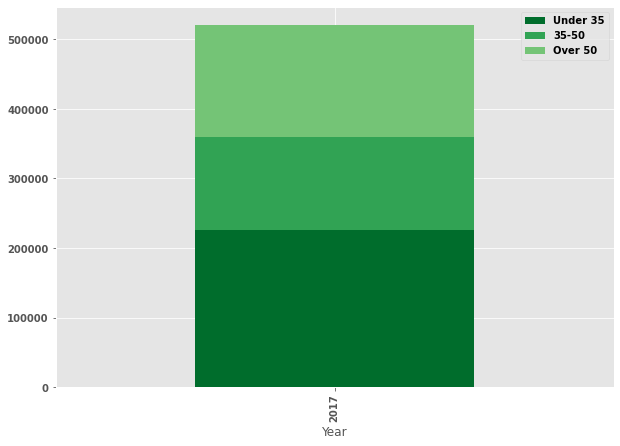

In [92]:
fig, ax = plt.subplots(figsize=(10,7))  

#months = df['Month'].drop_duplicates()
margin_bottom = np.zeros(len(df['Year'].drop_duplicates()))
colors = ["#006D2C", "#31A354","#74C476"]

for num, age_range in enumerate(age_ranges):
    values = list(df[df['Age Ranges'] == age_range].loc[:, 'Value'])

    df[df['Age Ranges'] == age_range].plot.bar(x='Year',y='Value', ax=ax, stacked=True, 
                                    bottom = margin_bottom, color=colors[num], label=age_range)
    margin_bottom += values

plt.show()

In [71]:
def count_voted(year):
    create_function = f"""    
    create or replace function count_voted() returns int as $$
        DECLARE  
            count_voted integer;
        BEGIN  
            return (select count(*) from {table_name(year)} where VOTED = 1);
        END;
    $$ LANGUAGE plpgsql;
    """
    cur.execute(create_function)
    cur.execute("select * from count_voted()")
    return cur.fetchone()[0]      

In [73]:
print(count_voted(2017))
print(count_voted(2018))
print(count_voted(2019))

189451
319069
242891
